# Lomb-Scargle Periodogram Analysis
**Author**: Emma Babula  
**Description**: This notebook performs a Lomb-Scargle periodogram analysis on the generated lightcurve data for each Centaur object and observing filter. It identifies the highest peak in the periodogram and avoids known alias periods (e.g. 6, 12, 24 hours). Each periodogram is saved as an individual PNG image and annotated with the best-fit period.

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import lombscargle
import matplotlib.pyplot as plt
import os

#### Derive the lombcargle periodograms and plot the results

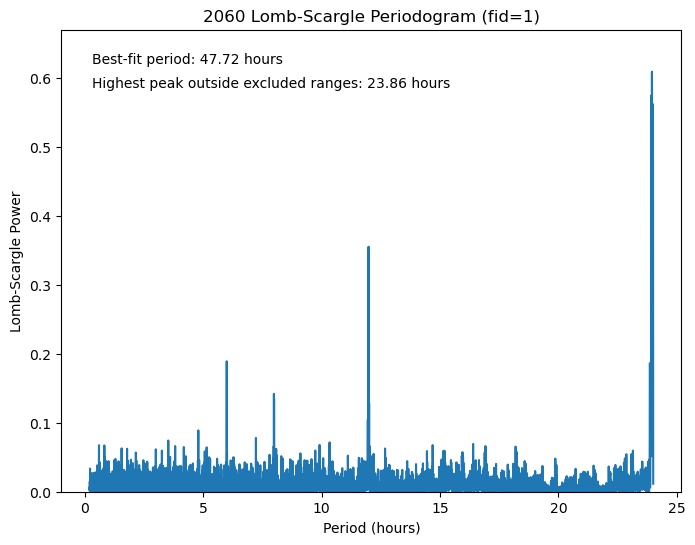

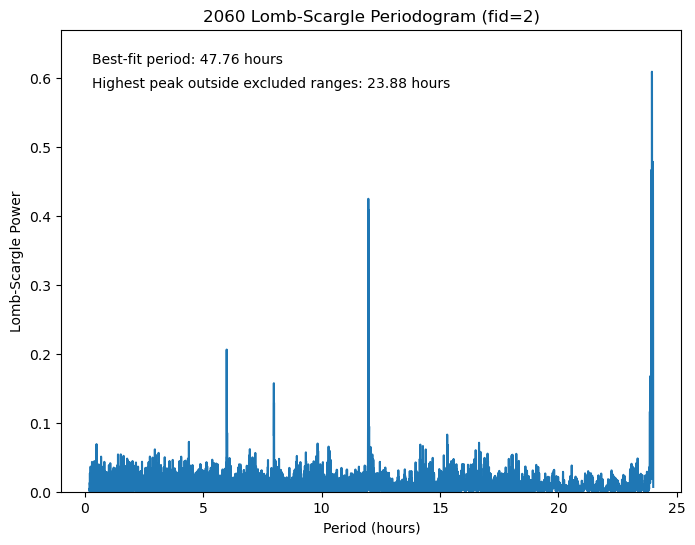

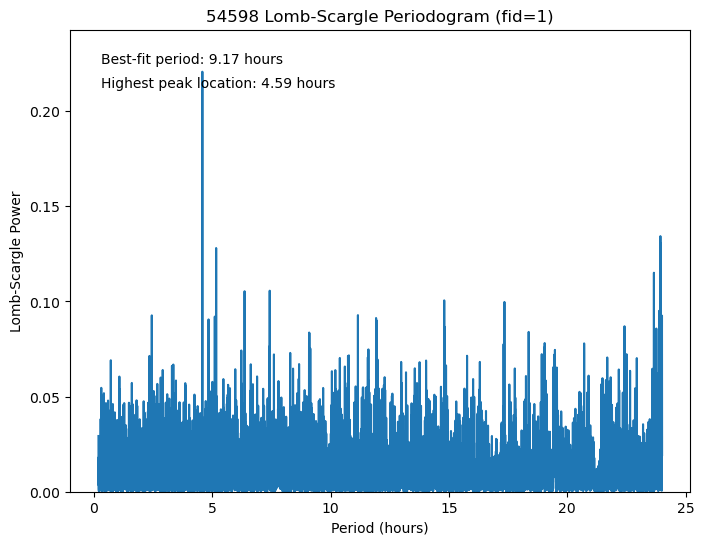

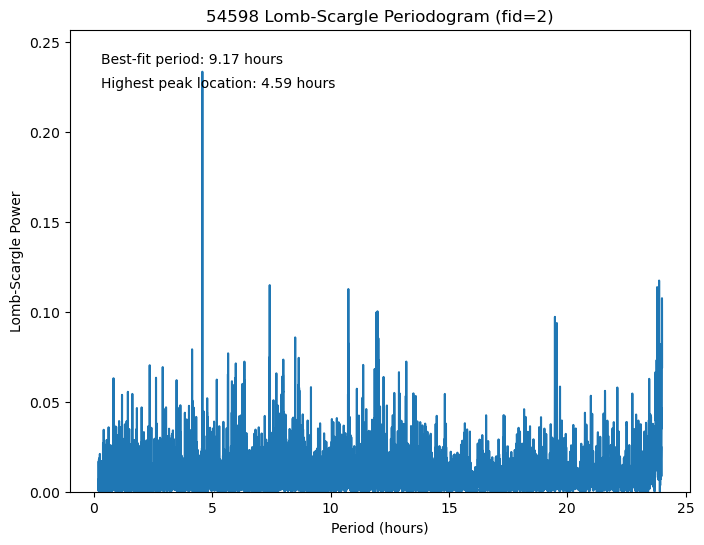

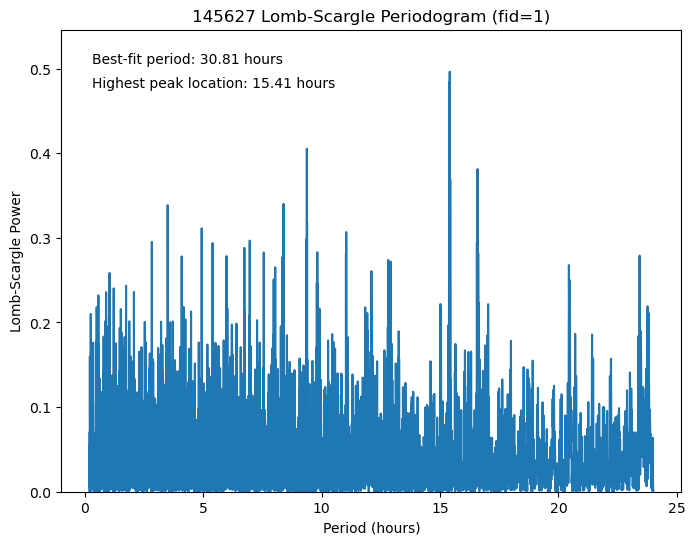

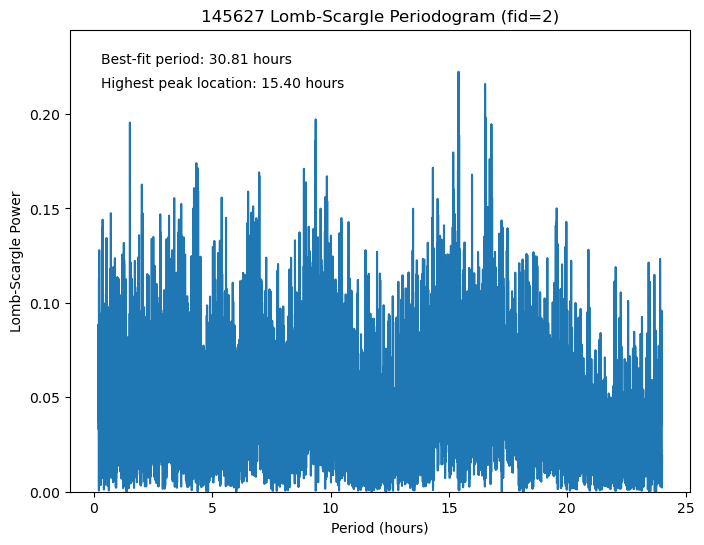

In [5]:
object_list = ['2060', '54598', '145627']

for object in object_list:
    for fid in [1, 2]:
        file_path = f'C:/Users/emmab/Github/Data/Lightcurve Data/{object}_data_fid{fid}.csv'
        
        if not os.path.exists(file_path):
            print(f"File {file_path} not found, skipping.")
            continue
        
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue
        
        time = df['hours'].values
        mag = df['H'].values
        merr = df['sigmapsf'].values
        
        # Choose a period grid (min, max, interval)
        periods = np.linspace(0.2, 24, 10000)
        ang_freqs = 2 * np.pi / periods

        power = lombscargle(time, mag - mag.mean(), ang_freqs)
        
        # Identify the original highest peak
        highest_peak_period = periods[np.argmax(power)]
        bestfit_original = 2 * highest_peak_period
        
        # Check if highest peak is in excluded ranges (5.9-6.1, 11.9-12.1, or 23.9-24.1 hours)
        if (5.9 <= highest_peak_period <= 6.1) or (11.9 <= highest_peak_period <= 12.1) or (23.9 <= highest_peak_period <= 24.1):
            # Mask out the excluded ranges
            mask = (periods < 5.9) | ((periods > 6.1) & (periods < 11.9)) | ((periods > 12.1) & (periods < 23.9)) | (periods > 24.1)
            masked_power = power[mask]
            masked_periods = periods[mask]
            
            # Identify highest peak outside masked ranges
            highest_peak_outside = masked_periods[np.argmax(masked_power)]
            bestfit_outside = 2 * highest_peak_outside
        else:
            highest_peak_outside = highest_peak_period
            bestfit_outside = bestfit_original
        
        # Normalize the power if the standard deviation is not zero
        N = len(time)
        mag_std = mag.std()
        if mag_std != 0:
            power *= 2 / (N * mag_std ** 2)
        
        # Plot the results
        plt.figure(figsize=(8, 6))
        plt.plot(periods, power)
        plt.ylim(0, power.max() * 1.1)
        plt.xlabel('Period (hours)')
        plt.ylabel('Lomb-Scargle Power')
        plt.title(f'{object} Lomb-Scargle Periodogram (fid={fid})')
    
        bestfit_txt = f'Best-fit period: {bestfit_outside:.2f} hours'
        plt.text(0.05, 0.95, bestfit_txt, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
        
        if (5.9 <= highest_peak_period <= 6.1) or (11.9 <= highest_peak_period <= 12.1) or (23.9 <= highest_peak_period <= 24.1):
            highest_peak_outside_txt = f'Highest peak outside excluded ranges: {highest_peak_outside:.2f} hours'
            plt.text(0.05, 0.90, highest_peak_outside_txt, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
        else:
            highest_peak_txt = f'Highest peak location: {highest_peak_period:.2f} hours'
            plt.text(0.05, 0.90, highest_peak_txt, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')


        plt.savefig(f'C:/Users/emmab/Github/Lombscargle Periodograms/Lombscargle Plots/{object}_fid{fid}_lombscargle.png')
        plt.show()